# Google's Inceptionv3 CNN

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim

In [ ]:
# check if gpu present
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Datasets and transforms

For Inception v3, image size SHOULD be 299 x 299, so below code not applicable, resize as done in next cell.

In [ ]:
# earlier had used ToTensor() of "transform" to convert PIL image to tensor directly
# This time using few more functions of "transform"

# transform_train = transforms.Compose([
#       transforms.RandomResizedCrop(224),
#       transforms.ToTensor(),
#       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

# transform_test = transforms.Compose([
#       transforms.RandomResizedCrop(224),
#       transforms.ToTensor(),
#       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
# ])

For inception input size is 299 x 299, so resize/transform

In [ ]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [ ]:
# trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
#                                         download = True, 
#                                         transform = transform_train) # applying transform in this last line

# testset = torchvision.datasets.CIFAR10(root = './data', train = False,
#                                         download = True, 
#                                         transform = transform_test)
                                        

In [ ]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True,
                                        download = True, 
                                        transform = transform_train) # applying transform in this last line

testset = torchvision.datasets.CIFAR10(root = './data', train = False,
                                        download = True, 
                                        transform = transform_test)
                                        

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
num_classes = 10

10 classes in CIFAR10

# Helper Functions

In [ ]:
# def evaluation(dataloader, model):
#   total, correct = 0, 0
#   for data in dataloader:
#     inputs, labels = data
#     inputs, labels = inputs.to(device), labels.to(device)
#     outputs = model(inputs)
#     _, pred = torch.max(outputs.data, 1) # index at which max value
#     total += labels.size(0)
#     correct += (pred == labels).sum().item()
#   return 100 * correct / total

Slight change in evaluation: See in the code of inception, during forward pass, it returns both final and auxillary output, so you have to take the aux outputs too. (though you won't use them)

Have to use this modified evaluation function (else error - data of inception not defined)

In [ ]:
def evaluation_inception(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs, aux_outputs = model(inputs) # this time model gives two outputs: output from final layer + from auxillary layers (only change)
    _, pred = torch.max(outputs.data, 1) # index at which max value
    total += labels.size(0)
    correct += (pred == labels).sum().item()
  return 100 * correct / total

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle = False)

# Inception Model

Torchvision

Repeating modules with Parallel paths and dangling (auxillary outputs - useful during training)

In [ ]:
inception = torchvision.models.inception_v3(pretrained = True)

In [ ]:
print(inception)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Note the recurring inception modules and very very large network.    
InceptionA, B, C, D, E (a class of those paralled layers) like BuildingBlock in ResNet.   
InceptionAux to make sure gradients flow through.

Finally comes fc (fully connected neural layer)

In [ ]:
for param in inception.parameters():
  param.requires_grad = False

Change number of classes in "auxillary" and "final" outputs from 1000 (which you can see above - out_features=1000) in the default loaded model to 10 which we require for our CIFAR dataset. Even auxillary since auxillary layers are almost similar to output layers, since that's where we'll be predicting the output and computing loss w.r.t. the actual labels.

Note number of output features even in InceptionAux is 1000. But number of input features is not the same as the output layer which is why we have to add them separately (done below).

First, auxillary

In [ ]:
aux_in_features = inception.AuxLogits.fc.in_features # this is the number of inputs to the auxillary layer which has to be retained
inception.AuxLogits.fc = nn.Linear(aux_in_features, num_classes) # only number of output labels change

In [ ]:
for param in inception.parameters():
  if(param.requires_grad): # auxillary and output give true for requires_grad though we made them all false since they have been newly build so replaces all previous values.
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])


Now output

In [ ]:
in_features = inception.fc.in_features
inception.fc = nn.Linear(in_features, num_classes)

In [ ]:
for param in inception.parameters():
  if(param.requires_grad):
    print(param.shape)

torch.Size([10, 768])
torch.Size([10])
torch.Size([10, 2048])
torch.Size([10])


Shows that now both auxillary and final output are changed (# classes)

### Training Inception

In [ ]:
inception = inception.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(inception.parameters(), lr = 0.01) # stochastic

In [ ]:
import copy

Changes in learning loop commented

Min loss 2.69
Iteration: 0/3125, Loss: 2.69
Min loss 1.91
Min loss 1.83
Min loss 1.49
Min loss 1.27
Min loss 1.21
Min loss 1.08
Iteration: 100/3125, Loss: 2.57
Min loss 0.99
Iteration: 200/3125, Loss: 1.98
Iteration: 300/3125, Loss: 2.15
Iteration: 400/3125, Loss: 1.91
Iteration: 500/3125, Loss: 1.53
Iteration: 600/3125, Loss: 1.47
Iteration: 700/3125, Loss: 1.88
Iteration: 800/3125, Loss: 1.51
Iteration: 900/3125, Loss: 1.66
Iteration: 1000/3125, Loss: 1.60
Iteration: 1100/3125, Loss: 1.70
Min loss 0.94
Iteration: 1200/3125, Loss: 2.30
Iteration: 1300/3125, Loss: 1.55
Min loss 0.87
Iteration: 1400/3125, Loss: 1.76
Iteration: 1500/3125, Loss: 2.22
Iteration: 1600/3125, Loss: 1.90
Iteration: 1700/3125, Loss: 1.89
Iteration: 1800/3125, Loss: 1.29
Iteration: 1900/3125, Loss: 1.98
Iteration: 2000/3125, Loss: 2.24
Iteration: 2100/3125, Loss: 2.41
Iteration: 2200/3125, Loss: 1.78
Iteration: 2300/3125, Loss: 1.76
Iteration: 2400/3125, Loss: 1.53
Iteration: 2500/3125, Loss: 2.26
Iteration: 260

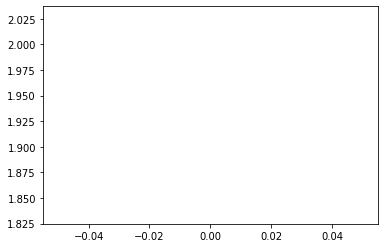

Iteration: 0/3125, Loss: 1.76
Iteration: 100/3125, Loss: 2.24
Iteration: 200/3125, Loss: 1.45
Iteration: 300/3125, Loss: 1.79
Iteration: 400/3125, Loss: 1.84
Iteration: 500/3125, Loss: 2.16
Iteration: 600/3125, Loss: 2.95
Iteration: 700/3125, Loss: 2.26
Iteration: 800/3125, Loss: 2.02
Iteration: 900/3125, Loss: 1.19
Iteration: 1000/3125, Loss: 1.21
Iteration: 1100/3125, Loss: 1.47
Iteration: 1200/3125, Loss: 1.44
Iteration: 1300/3125, Loss: 2.28
Iteration: 1400/3125, Loss: 1.76
Iteration: 1500/3125, Loss: 2.37
Iteration: 1600/3125, Loss: 1.90
Iteration: 1700/3125, Loss: 1.48
Iteration: 1800/3125, Loss: 2.30
Iteration: 1900/3125, Loss: 2.49
Iteration: 2000/3125, Loss: 2.01
Iteration: 2100/3125, Loss: 1.83
Iteration: 2200/3125, Loss: 1.95
Iteration: 2300/3125, Loss: 1.53
Iteration: 2400/3125, Loss: 1.54
Iteration: 2500/3125, Loss: 2.01
Iteration: 2600/3125, Loss: 3.21
Iteration: 2700/3125, Loss: 1.49
Iteration: 2800/3125, Loss: 1.33
Iteration: 2900/3125, Loss: 2.05
Iteration: 3000/3125, 

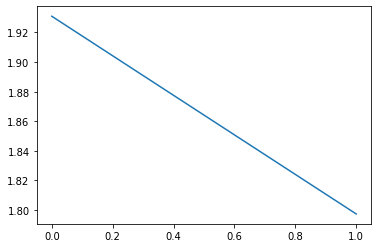

Iteration: 0/3125, Loss: 2.12
Iteration: 100/3125, Loss: 1.67
Iteration: 200/3125, Loss: 2.00
Iteration: 300/3125, Loss: 1.85
Iteration: 400/3125, Loss: 1.75
Iteration: 500/3125, Loss: 1.67
Iteration: 600/3125, Loss: 1.71
Iteration: 700/3125, Loss: 2.23
Min loss 0.64
Iteration: 800/3125, Loss: 2.27
Iteration: 900/3125, Loss: 1.38
Iteration: 1000/3125, Loss: 1.44
Iteration: 1100/3125, Loss: 1.03
Iteration: 1200/3125, Loss: 1.73
Iteration: 1300/3125, Loss: 1.67
Iteration: 1400/3125, Loss: 2.25
Iteration: 1500/3125, Loss: 2.09
Iteration: 1600/3125, Loss: 2.16
Iteration: 1700/3125, Loss: 2.03
Iteration: 1800/3125, Loss: 2.17
Iteration: 1900/3125, Loss: 1.63
Iteration: 2000/3125, Loss: 1.75
Iteration: 2100/3125, Loss: 1.73
Iteration: 2200/3125, Loss: 1.65
Iteration: 2300/3125, Loss: 1.87
Iteration: 2400/3125, Loss: 2.00
Iteration: 2500/3125, Loss: 1.46
Iteration: 2600/3125, Loss: 2.04
Iteration: 2700/3125, Loss: 1.72
Iteration: 2800/3125, Loss: 1.66
Iteration: 2900/3125, Loss: 2.14
Iteratio

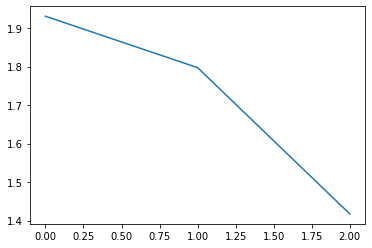

Iteration: 0/3125, Loss: 1.36
Iteration: 100/3125, Loss: 1.89
Iteration: 200/3125, Loss: 1.41
Iteration: 300/3125, Loss: 1.81
Iteration: 400/3125, Loss: 1.94
Iteration: 500/3125, Loss: 2.86
Iteration: 600/3125, Loss: 1.32
Iteration: 700/3125, Loss: 2.65
Iteration: 800/3125, Loss: 1.92
Iteration: 900/3125, Loss: 1.81
Iteration: 1000/3125, Loss: 1.36
Iteration: 1100/3125, Loss: 2.00
Iteration: 1200/3125, Loss: 1.72
Iteration: 1300/3125, Loss: 2.08
Iteration: 1400/3125, Loss: 1.37
Iteration: 1500/3125, Loss: 2.43
Iteration: 1600/3125, Loss: 1.60
Iteration: 1700/3125, Loss: 1.59
Iteration: 1800/3125, Loss: 2.47
Iteration: 1900/3125, Loss: 1.31
Iteration: 2000/3125, Loss: 1.65
Iteration: 2100/3125, Loss: 1.41
Iteration: 2200/3125, Loss: 2.03
Iteration: 2300/3125, Loss: 1.30
Iteration: 2400/3125, Loss: 2.12
Iteration: 2500/3125, Loss: 1.63
Iteration: 2600/3125, Loss: 2.05
Iteration: 2700/3125, Loss: 1.68
Iteration: 2800/3125, Loss: 1.67
Iteration: 2900/3125, Loss: 1.65
Iteration: 3000/3125, 

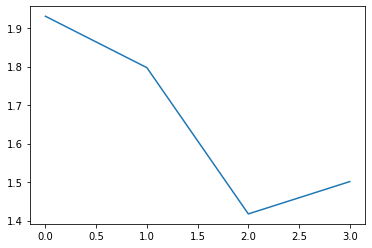

In [ ]:
loss_epoch_arr = []
max_epochs = 4

n_iters = np.ceil(50000/batch_size)

min_loss = 1000

for epoch in range(max_epochs):

  for i, data in enumerate(trainloader, 0):

    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    opt.zero_grad()

    # one more output
    outputs, aux_outputs = inception(inputs)
    # sum up losses and then propagate (new feature in deep NNs)
    # main weightage given to main loss (weightage = 1), and smaller weightage to previous ones (0.3)
    loss = loss_fn(outputs, labels) + 0.3*loss_fn(aux_outputs, labels)

    loss.backward() 
    opt.step() 

    if loss.item() < min_loss: 
      min_loss = loss.item() 
      best_model = copy.deepcopy(inception.state_dict())
      print("Min loss %0.2f" % min_loss)

    if i%100 == 0:
      print("Iteration: %d/%d, Loss: %0.2f" % (i, n_iters, loss.item()))

    del inputs, labels, outputs
    torch.cuda.empty_cache()


  loss_epoch_arr.append(loss.item())

  # change evaluation metric
  print("Epoch: %d/%d, Test acc = %0.2f, Train acc = %0.2f" %(
      epoch, max_epochs,
      evaluation_inception(testloader, inception), evaluation_inception(trainloader, inception)))
  
  plt.plot(loss_epoch_arr)
  plt.show()

Extremely fast training - much faster than VGGNet

Note: https://stackoverflow.com/questions/53438146/how-can-i-change-the-padded-input-size-per-channel-in-pytorch  
Input should be resized to 299 x 299 for Inceptionv3 else error.

In [ ]:
inception.load_state_dict(best_model)
print(evaluation_inception(trainloader, inception), evaluation_inception(testloader, inception))

48.352 48.36


Accuracy slightly better than VGGNet.